In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from deepchem import metrics
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.model_selection import GridSearchCV


In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')

In [4]:
X = bbb_df.drop(columns=["Drug", "SMILES", 'permeable'])
Y = bbb_df['permeable']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

## Optimized SVM

In [5]:
SVM_best = SVC(C=0.1, gamma=1, kernel='linear', probability=True).fit(X_train, y_train)

## Scaffold Split

In [9]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

## Model Training and Predictions

In [10]:
# Train Decision Tree classifier
SVM_best = SVM_best.fit(train_scaff.X,train_scaff.y)

In [11]:
# Predict the response for test dataset
y_pred_scaff = SVM_best.predict(test_scaff.X)

In [12]:
y_pred_scaff_prob = SVM_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
309,CCCCc1nc(c(n1Cc1ccc(cc1)c1ccccc1c1[nH]nnn1)CO)Cl,1.000000
28,CCc1sc2c(c1)C(=NCC(=O)N2C)c1ccccc1Cl,1.000000
130,CN(CCc1cc2cccc3c2n1c1ccccc1CC3)Cc1ccccc1,0.999999
33,Brc1ccc2c(c1)C(=NCC(=O)N2)c1ccccn1,0.999999
10,CC(=O)OCC(=O)[C@]12OC3(CCCC3)O[C@@H]2C[C@H]2[C...,0.999999
...,...,...
262,OC(=O)c1[nH]cnc1C(=O)N[C@@H](C(=O)N[C@H]1[C@H]...,0.000363
223,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](NC(=O)C3=CC=C(...,0.000331
274,Cc1sc(nn1)SCC1=C(N2[C@H](SC1)[C@H](NC(=O)CN1C=...,0.000175
205,CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)[C@]2(O)C(=O)C...,0.000020


## Feature Importances

In [17]:
# get importance
dt_importance = SVM_best.coef_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance[0]) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[0][i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [21]:
feature_importance

,Feature,Importance
5,5,-0.386517
349,357,-0.325430
231,237,-0.316579
139,143,-0.304241
934,953,-0.272490
...,...,...
632,646,0.188514
134,138,0.190203
518,530,0.194462
812,828,0.208082


Text(0.5, 1.0, 'Top 10 SVM Feature Importances')

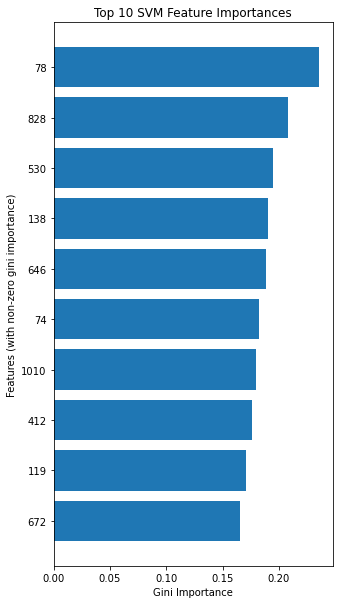

In [19]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 SVM Feature Importances')

## Fragment Extraction

In [22]:
def get_fragments(smiles_set, feature_list):
    fragments_df = pd.DataFrame(columns=['Fragment', 'Count'])
    r=2
    d=1024
    for smile in smiles_set:
        m = Chem.MolFromSmiles(smile)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(m,r,d,bitInfo=info)
        fragments = []
        for bit in info.keys():
            if bit in feature_list:
                root_atom = info[bit][0][0]
                radius = info[bit][0][1]
                env = Chem.FindAtomEnvironmentOfRadiusN(m,radius,root_atom)
                amap={}
                submol=Chem.PathToSubmol(m,env,atomMap=amap)
                if amap:
                    fragment = Chem.MolToSmiles(submol, rootedAtAtom=amap[root_atom],canonical=False)
                else:
                    fragment = Chem.MolToSmiles(submol)
                fragments.append(fragment)
        
        for fragment in fragments:
            if fragment in fragments_df['Fragment'].values:
                index = fragments_df.index[fragments_df['Fragment'] == fragment]
                fragments_df.at[index[0],'Count'] = fragments_df.at[index[0],'Count'] + 1
            else:
                row = {'Fragment': [fragment], 'Count': [1]}
                row_df = pd.DataFrame(data=row)
                fragments_df = pd.concat([fragments_df, row_df], ignore_index=True)
    return fragments_df

In [23]:
important_feature_list = np.array(feature_importance['Feature'].values).astype(int)
important_feature_list

array([  5, 357, 237, ..., 530, 828,  78])

### 1.1 Fragment Extraction For Top 50 Probability Predictions, Using All Important Features

In [24]:
top_50 = prob_test_df['SMILES'].tolist()[:50]
fragments_prob_high = get_fragments(top_50, important_feature_list)

In [25]:
fragments_prob_high = fragments_prob_high.sort_values(by=['Count'], ascending=False)
fragments_prob_high.head(20)

,Fragment,Count
0,,423
1,c(c)c,100
7,c(cc)cc,55
26,C(C)C,54
23,c(C)(c)c,39
13,c(c(C)c)cc,34
43,C(N)C,26
48,O=C,25
164,C(C)N,23
71,N(C)(C)C,21


### 1.2 Fragment Extraction For Lowest 50 Probability Predictions

In [32]:
low_50 = prob_test_df['SMILES'].tolist()[-50:]
fragments_prob_low = get_fragments(low_50, important_feature_list)

In [35]:
fragments_prob_low = fragments_prob_low.sort_values(by=['Count'], ascending=False)
fragments_prob_low.head(20)

,Fragment,Count
1,,694
16,O=C,92
65,OC,55
19,N(C)C,55
51,N(C)(C)C,53
55,c(c)c,53
0,C(N)(=O)C,49
54,S(C)C,44
61,CC,39
8,C(C)(=O)N,38


### 2.1 Fragment Extraction for Permeable Molecules in Dataset, Using Top 20 Most Important Features

In [36]:
fragments_perm = get_fragments(bbb_df[bbb_df['permeable'] == 1]['SMILES'], important_feature_list[-20:])

In [37]:
fragments_perm = fragments_perm.sort_values(by=['Count'], ascending=False)
fragments_perm.head(20)

,Fragment,Count
106,C(C)(C)(C)C,232
8,C(C)C,226
12,N(C)(C)C,201
107,C(C(C)=O)=CC,109
13,c(C)(c)c,109
26,c(c)(c)F,61
16,C(N)C,52
53,c(c)(C)c,44
51,C(CN)N(C)C,44
14,c(c)(c)C,43


### 2.1 Fragment Extraction for Non-Permeable Molecules in Dataset, Using Top 20 Most Important Features

In [38]:
fragments_nonperm = get_fragments(bbb_df[bbb_df['permeable'] == 0]['SMILES'], important_feature_list[-20:])

In [39]:
fragments_nonperm = fragments_nonperm.sort_values(by=['Count'], ascending=False)
fragments_nonperm.head(20)

,Fragment,Count
56,c(c(C)n)sc,26
7,N(C)(C)C,13
13,c(c)(c)C,13
4,C(C)C,13
29,c(C)(c)c,11
58,C(C)c,11
39,C(O)C,7
0,o(c)c,7
8,C(N)C,6
38,c([nH])(c)c,6


## Example: Visualizing Fragments

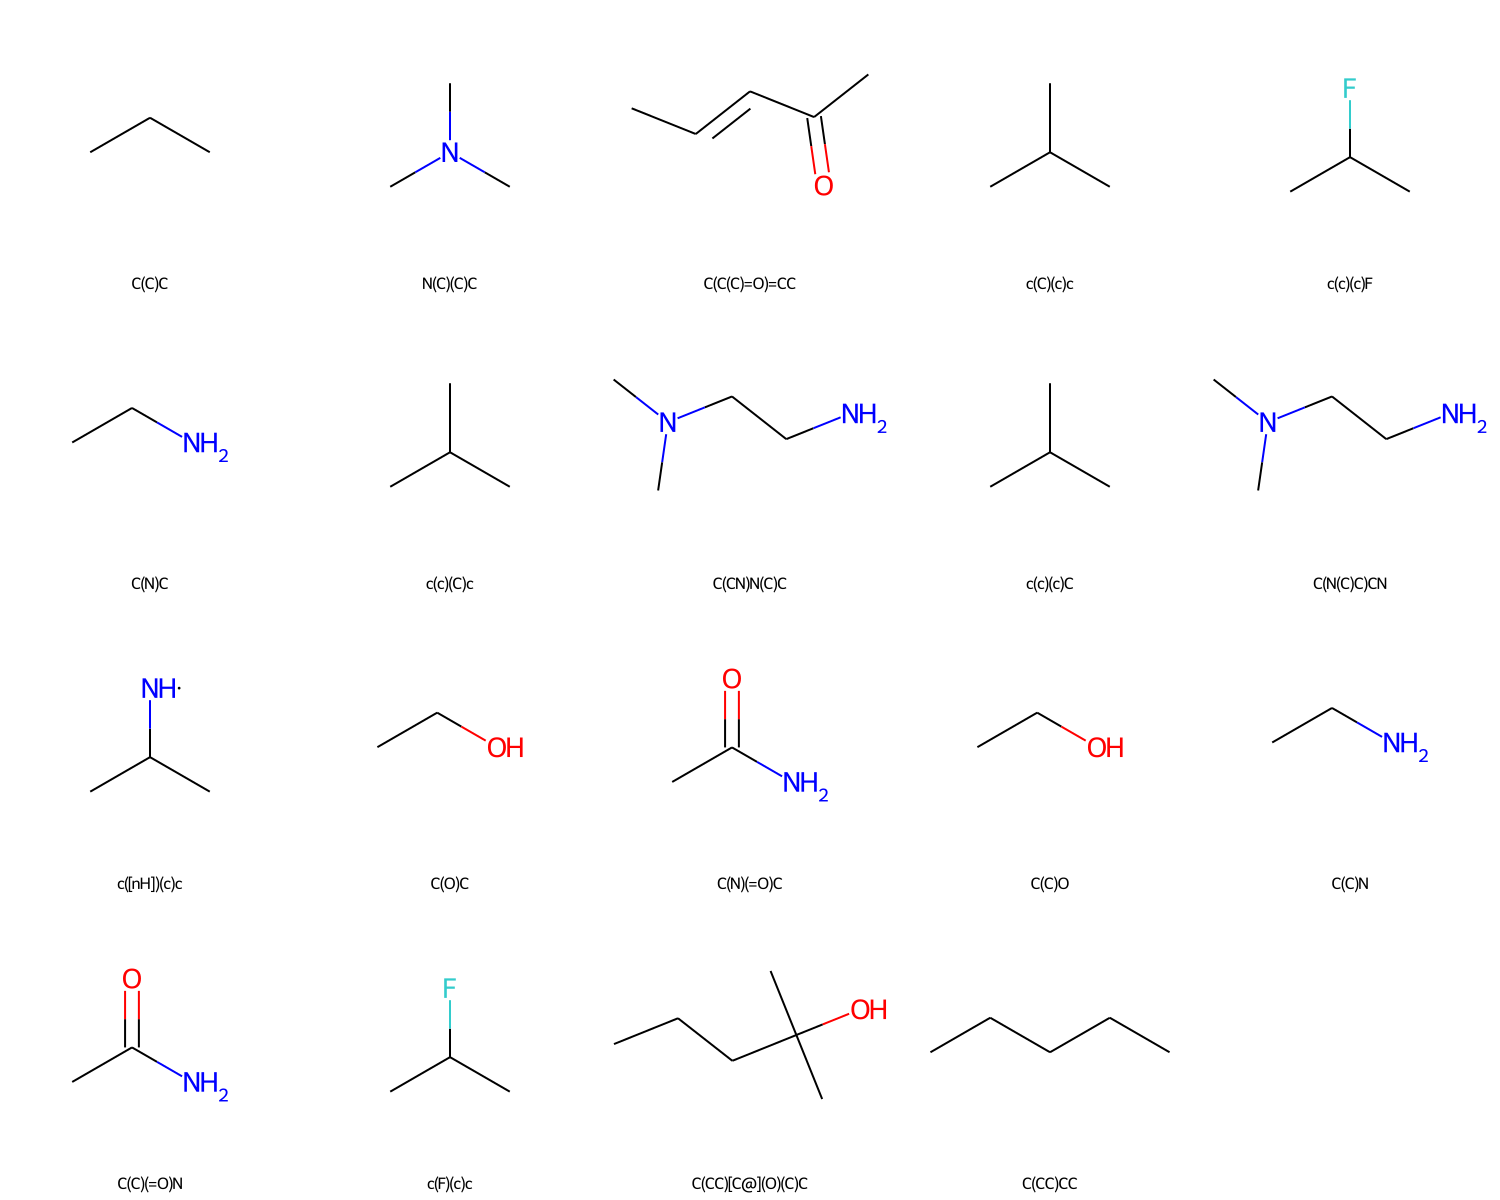

In [40]:
smile_lst = fragments_perm['Fragment'].tolist()[1:20]
smile_lst_upp = [s.upper() for s in smile_lst]

mol_lst = [Chem.MolFromSmiles(s) for s in smile_lst_upp]

from rdkit.Chem import (
    AllChem,
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys
)

Draw.MolsToGridImage(
    mol_lst, 
    molsPerRow=5, 
    subImgSize=(300, 300), 
    legends= smile_lst
)